<a href="https://colab.research.google.com/github/shamim-hussain/cnn_vae_gan_rl/blob/main/cnn_on_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Classification using CNN
### Problem Description
We will perform a classification task on the Fashion MNIST dataset:
https://github.com/zalandoresearch/fashion-mnist
The dataset contains 28x28 grayscale(8bit) images of different fashion articles. There are 10 different classes. The training set contains 60000 examples whereas the test set contains 10000 examples. All the classes have same number of examples so it is a blanced classification problem.

# Download, prepare and visualize the dataset

## Download the Dataset

The download links and the coad for loading the dataset in NumPy format can be found at https://github.com/zalandoresearch/fashion-mnist

In [ ]:
'''From: https://github.com/zalandoresearch/fashion-mnist'''

!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-10-26 03:45:12--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.16
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.171.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.2MB/s    in 2.2s    

2021-10-26 03:45:14 (11.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-10-26 03:45:14--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.16
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

Load the dataset in NumPy format

In [ ]:

'''From: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py'''
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X_train, Y_train = load_mnist('./', kind='train') # Training set
X_test, Y_test = load_mnist('./', kind='t10k') # Test set

## Explore and Preprocess the data

Let us first explore the shape and datatypes of the examples and labels

In [ ]:
print('Shape of data:', X_train.shape)
print('Type of data:', X_train.dtype)
print('Shape of data:', Y_train.shape)
print('Type of labes:', Y_train.dtype)

Shape of data: (60000, 784)
Type of data: uint8
Shape of data: (60000,)
Type of labes: uint8


We can reshape and visualize images from each class

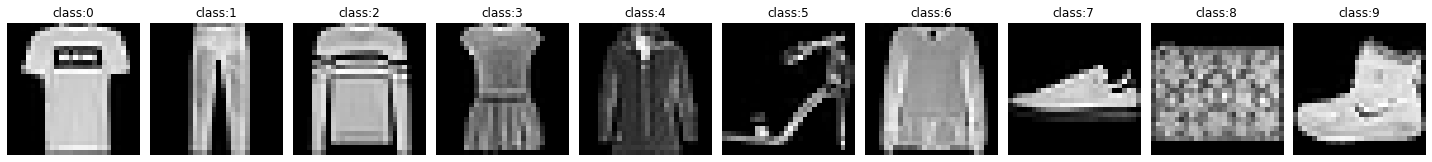

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][0]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

### Conversion into floating point image with channel dimension

We will convert the images into floating point formats - with intensity values between $[0\ 1]$. Additionally we will add a channel dimension (single channel for grayscale image) to feed them as inputs to CNNs.

In [ ]:
X_train = X_train.reshape(-1,28,28,1).astype('float32')/255
X_test = X_test.reshape(-1,28,28,1).astype('float32')/255

Y_train = Y_train.astype('int64')
Y_test = Y_test.astype('int64')

### Train-validation split 

A validation split is created for hyperparameter selection.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1,
                                                  stratify=Y_train, random_state=777)

# CNN Model definition and training

## Model definintion

The following design choices have been made
* We will use a 2 blocks of convolutional layers.
* Each block will have a structure [Conv, Conv, MaxPool].
* The number of channels will be doubled for the second layer, since we are contracting the spatial dimension, it is customary to expand the channel dimension.
* We will pool by a grater factor (4x) in the first block than the socond one (2x) to because adacent pixels are supposed to have a lot of redudancies which can be quickly reduced.
* Also we will use bigger filters (5x5) in the first block than the second one (3x3) due to the same reason.
* After the convolutional layers we will flatten the dimensions and apply two linear (dense) layers.
* We will use dropout and L2 regularization to prevent overfitting. We found that a dropout rate of 0.2 (which is quite high compared to a typical value of 0.1) works better for this unaugmented dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, losses, metrics


dropout_prob = 0.2
l2_reg = regularizers.l2(5e-4)
channel_mult = 1

model_layers = [
    layers.ZeroPadding2D(2, name='pad2', input_shape=(28,28,1)),
    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv11'),
    layers.Dropout(dropout_prob, name='drp11'),

    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv12'),
    layers.Dropout(dropout_prob, name='drp12'),
    layers.MaxPool2D((4,4), name='pool1'),


    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv21'),
    layers.Dropout(dropout_prob, name='drp21'),

    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv22'),
    layers.Dropout(dropout_prob, name='drp22'),
    layers.MaxPool2D((2,2), name='pool2'),


    layers.Flatten(name='flatten'),
    layers.Dense(round(64*channel_mult), kernel_regularizer=l2_reg, activation='elu', name='dense1'),
    layers.Dense(10, activation=None, name='dense2')
]

model = models.Sequential(model_layers, name='trained_on_given_data')
model.summary()

Model: "trained_on_given_data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
drp11 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv12 (Conv2D)              (None, 32, 32, 32)        25632     
_________________________________________________________________
drp12 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv21 (Conv2D)              (None, 8, 8, 64)

## Training the model


Now we will train the model. 
* We will use the cross-entropy loss.
* We will use accuracy as evaluation metric, because this is a balanced classification problem.
* We will use the Adam optimizer with an intial learning rate of $10^{-3}$.
* The learning will be decayed exponentially by a factor of 0.9 at each epoch. We will train the model for 50 epochs, beyond these number of epochs, the model just overfits the training data.

In [ ]:
lr_schedule = optimizers.schedules.ExponentialDecay(1e-3, len(X_train)//64, 0.9)
optim = optimizers.Adam(lr_schedule)
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent')
acc = metrics.SparseCategoricalAccuracy(name='acc')

model.compile(optim, loss_fn, [acc])

hist_obj = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
844/844 [==============================] - 5s 6ms/step - loss: 0.6117 - acc: 0.8243 - val_loss: 0.4738 - val_acc: 0.8707
Epoch 2/50
844/844 [==============================] - 5s 6ms/step - loss: 0.4402 - acc: 0.8805 - val_loss: 0.3891 - val_acc: 0.8973
Epoch 3/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3904 - acc: 0.8931 - val_loss: 0.3698 - val_acc: 0.8978
Epoch 4/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3607 - acc: 0.9021 - val_loss: 0.3557 - val_acc: 0.9003
Epoch 5/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3381 - acc: 0.9086 - val_loss: 0.3676 - val_acc: 0.8995
Epoch 6/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3218 - acc: 0.9128 - val_loss: 0.3217 - val_acc: 0.9117
Epoch 7/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3083 - acc: 0.9166 - val_loss: 0.3174 - val_acc: 0.9162
Epoch 8/50
844/844 [==============================] - 5s 6ms/step - loss: 0.

We see that, we get a final validation accuracy of 93.08%.

## Final Evaluation

Now we will evaluate our model on the test data.

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, batch_size=64)
print(f'Test accuracy with given data: {acc:0.3%}')

157/157 [==============================] - 0s 3ms/step - loss: 0.2835 - acc: 0.9265
Test accuracy with given data: 92.650%


We see that we get a final test accuracy of 92.65%.

# VGG-16 Model Definition and Training

## Model Definition

Now we will use a VGG-16 model pretrained on the ImageNet dataset on our given dataset.
* The lowest resolution of input for a VGG-16 model is 32x32. So, input 28x28 images will be padded to form 32x32 images.
* VGG-16 takes 3 color channels as input. So we will repeat the single channel in grayscale images to produce the color channels.
* We will only transfer ImageNet weights for the convolutional layers. We will add 2 additional linear layers (initialized to random values) on the flattened output which will perform the final classification.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models, optimizers, regularizers, losses, metrics


base_model = VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')

model_layers = [
    layers.ZeroPadding2D(2, name='pad2', input_shape=(28,28,1)),
    layers.Lambda(lambda v: tf.tile(v, (1,1,1,3)), name='gray2rgb'),
    base_model,
    layers.Flatten(name='flatten'),
    layers.Dense(128, activation='relu', name='dense1'),
    layers.Dense(10, activation=None, name='dense2')
]

model_pretrained = models.Sequential(model_layers, name='model_pretrained')

## Training

We will perform the training in two steps.
1. First, we will freeze the convolutional layers and only train the final linear layers (which were randomly initialized).
2. Then we will fine-tune the whole model.

It is customary to train pre-trained model in these two stages to efficiently transfer the learned knowledge. Also, it usually makes the whole training process faster.

### Training the linear layers
We will use similar settings for training and evaluation - optimizers, loss, metrics etc.

In [ ]:
base_model.trainable = False

lr_schedule = optimizers.schedules.ExponentialDecay(1e-3, len(X_train)//64, 0.95)
optim = optimizers.Adam(lr_schedule)
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent')
acc = metrics.SparseCategoricalAccuracy(name='acc')

model_pretrained.compile(optim, loss_fn, [acc])

model_pretrained.summary()

Model: "model_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
gray2rgb (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               65664     
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________

In [ ]:
hist_obj = model_pretrained.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
844/844 [==============================] - 7s 9ms/step - loss: 0.6021 - acc: 0.7896 - val_loss: 0.4702 - val_acc: 0.8317
Epoch 2/20
844/844 [==============================] - 7s 8ms/step - loss: 0.4350 - acc: 0.8419 - val_loss: 0.4153 - val_acc: 0.8465
Epoch 3/20
844/844 [==============================] - 7s 8ms/step - loss: 0.3941 - acc: 0.8556 - val_loss: 0.3938 - val_acc: 0.8580
Epoch 4/20
844/844 [==============================] - 7s 9ms/step - loss: 0.3724 - acc: 0.8664 - val_loss: 0.3868 - val_acc: 0.8537
Epoch 5/20
844/844 [==============================] - 7s 8ms/step - loss: 0.3549 - acc: 0.8700 - val_loss: 0.3683 - val_acc: 0.8628
Epoch 6/20
844/844 [==============================] - 7s 8ms/step - loss: 0.3418 - acc: 0.8751 - val_loss: 0.3617 - val_acc: 0.8653
Epoch 7/20
844/844 [==============================] - 8s 9ms/step - loss: 0.3309 - acc: 0.8786 - val_loss: 0.3486 - val_acc: 0.8737
Epoch 8/20
844/844 [==============================] - 7s 8ms/step - loss: 0.

### Finetuning the whole model
We will use similar settings for training and evaluation - optimizers, loss, metrics etc.

In [ ]:
base_model.trainable = True

lr_schedule = optimizers.schedules.ExponentialDecay(1e-4, len(X_train)//64, 0.95)
optim = optimizers.Adam(lr_schedule)
model_pretrained.compile(optim, loss_fn, [acc])

model_pretrained.summary()

Model: "model_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
gray2rgb (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               65664     
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 14,781,642
Trainable params: 14,781,642
Non-trainable params: 0
______________________________________

In [ ]:
hist_obj = model_pretrained.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val))


Epoch 1/20
844/844 [==============================] - 24s 28ms/step - loss: 0.3773 - acc: 0.8677 - val_loss: 0.2523 - val_acc: 0.9095
Epoch 2/20
844/844 [==============================] - 23s 27ms/step - loss: 0.2415 - acc: 0.9118 - val_loss: 0.2143 - val_acc: 0.9220
Epoch 3/20
844/844 [==============================] - 23s 27ms/step - loss: 0.2052 - acc: 0.9257 - val_loss: 0.2160 - val_acc: 0.9243
Epoch 4/20
844/844 [==============================] - 23s 27ms/step - loss: 0.1757 - acc: 0.9349 - val_loss: 0.1971 - val_acc: 0.9280
Epoch 5/20
844/844 [==============================] - 23s 27ms/step - loss: 0.1533 - acc: 0.9444 - val_loss: 0.2312 - val_acc: 0.9153
Epoch 6/20
844/844 [==============================] - 23s 27ms/step - loss: 0.1338 - acc: 0.9509 - val_loss: 0.2000 - val_acc: 0.9377
Epoch 7/20
844/844 [==============================] - 23s 27ms/step - loss: 0.1128 - acc: 0.9588 - val_loss: 0.2095 - val_acc: 0.9283
Epoch 8/20
844/844 [==============================] - 23s 27ms

We see that we get a final validation set accuracy of 93.72%, which is higher than that of the CNN trained from scratch in the previous step.

## Final evaluation

Now we will evaluate the fine-tuned model on the test set.

In [ ]:
loss, acc = model_pretrained.evaluate(X_test, Y_test, batch_size=64)
print(f'Test accuracy with pretrained model: {acc:0.3%}')

157/157 [==============================] - 1s 8ms/step - loss: 0.3436 - acc: 0.9387
Test accuracy with pretrained model: 93.870%


We see that, we get a final test accuracy of 93.87% which is much higher than the test accuracy for the CNN trained from screatch (i.e. 92.65%).

## Differences Observed
We observed the following differences for the pre-trained VGG-16 model, compared to the CNN trained from scratch.
* The pre-trained model acheives a much higher accuracy (93.87%) than the CNN trained from scratch (92.65%)
* Although, the pre-trained model was much bigger than the CNN used in previous step, it was much faster to train.

Both of these are due to the fact that we are transferring knowledge learned by the network while training on the ImageNet dataset, which allows it to start from an initialization that produces good visual representations of the input images, rather than random initialization (i.e. intitilation from scratch).

# CNN Model Definition and Training on Augmented Data

Now we will apply augmentation on the dataset and train another CNN on the augmented data.

## Augmentation

The dataset does not contain rotated, shifted or flipped images of fashion articles. However, we can apply the following augmentations on the images - 
1. Affine transformation: We apply slight random affine transformations on the images which zooms (horizontally or vertically) and sheers the image by ceration ammount.
2. Gamma shift: We change the intesity values of the pixels by a random gamma transformation which brightens or dims the image by certain amount.
3. Gaussian blur: We apply a random gaussian blur filter on the image which randomly reduces its sharpness.

We will apply these augmentations in a randomly chosen sequence.

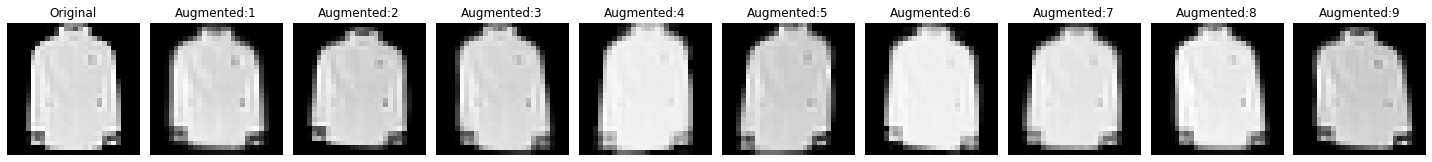

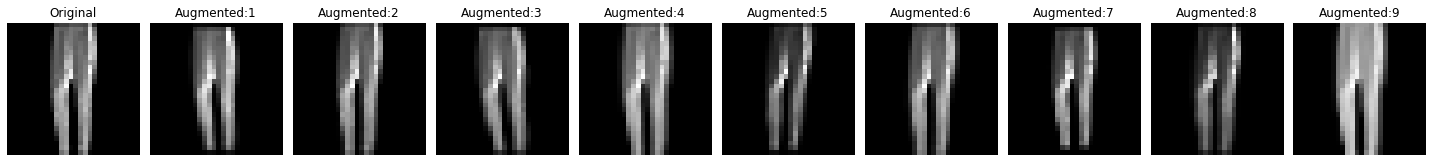

In [ ]:
import cv2
import random

ref_pts = np.float32([[8, 8], [8, 17], [17, 14]])

def augment_affine(X):
    rand_val = np.random.uniform(low=-.5, high=.5, 
                                 size=(3,2)).astype(np.float32)
    dst_pts = ref_pts + rand_val
    M = cv2.getAffineTransform(ref_pts,dst_pts)
    return cv2.warpAffine(X, M, (28,28))

def augment_gamma(X):
    rand_val = np.random.uniform(low=.5, high=2., 
                                 size=()).astype(np.float32)
    return X ** rand_val

def augment_gaussian(X):
    rand_val = np.random.uniform(low=0., high=.5, 
                                 size=()).astype(np.float32)
    return cv2.GaussianBlur(X, (5,5), rand_val)

augment_fns = [augment_gaussian,augment_gamma,augment_affine]
def augment(X, multiples):
    out = []
    for _ in range(multiples):
        X_t = X
        random.shuffle(augment_fns)
        for f in augment_fns:
            X_t = f(X_t)
        out.append(X_t)
    return out

plt.figure(figsize=[20,5])
original = X_train[0].squeeze()
augmented = augment(original, 9)

plt.subplot(1,10,1)
plt.imshow(original,cmap='gray')
plt.axis('off')
plt.title(f'Original')
for y in range(9):
    plt.subplot(1,10,2+y)
    plt.imshow(augmented[y],cmap='gray')
    plt.axis('off')
    plt.title(f'Augmented:{y+1}')
plt.tight_layout()


plt.figure(figsize=[20,5])
original = X_train[1].squeeze()
augmented = augment(original, 9)

plt.subplot(1,10,1)
plt.imshow(original,cmap='gray')
plt.axis('off')
plt.title(f'Original')
for y in range(9):
    plt.subplot(1,10,2+y)
    plt.imshow(augmented[y],cmap='gray')
    plt.axis('off')
    plt.title(f'Augmented:{y+1}')
plt.tight_layout()

Now we will add 9 augmented variants of each image in the dataset to increase the size of the training dataset tenfold.

In [ ]:
from tqdm import tqdm

multiples = 9

X_train_augmented = []
Y_train_augmented = []

for X,Y in tqdm(zip(X_train.squeeze(-1), Y_train), 
                total=len(Y_train)):
    X_train_augmented.extend(augment(X,multiples))
    Y_train_augmented.extend([Y]*multiples)

X_train_augmented = np.expand_dims(np.stack(X_train_augmented, axis=0), axis=-1)
Y_train_augmented = np.stack(Y_train_augmented)

X_train_augmented = np.concatenate([X_train, X_train_augmented],axis=0)
Y_train_augmented = np.concatenate([Y_train, Y_train_augmented],axis=0)

100%|██████████████████████████████████████████████████████████████████████████| 54000/54000 [00:24<00:00, 2210.58it/s]


## Model definition

We will use similar model architecture as in part 1. But we made 2 important changes - 
1. With the augmented data we were able to train a bigger model without overfitting the training data. We doubled the number of channels for the CNN layers.
2. Also, regularization is much less necessary to prevent overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, losses, metrics


dropout_prob = 0.1
l2_reg = regularizers.l2(5e-4)
channel_mult = 2

model_layers = [
    layers.ZeroPadding2D(2, name='pad2', input_shape=(28,28,1)),
    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv11'),
    layers.Dropout(dropout_prob, name='drp11'),

    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv12'),
    layers.Dropout(dropout_prob, name='drp12'),
    layers.MaxPool2D((2,2), name='pool1'),


    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv21'),
    layers.Dropout(dropout_prob, name='drp21'),

    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv22'),
    layers.Dropout(dropout_prob, name='drp22'),
    layers.MaxPool2D((2,2), name='pool2'),

    layers.Conv2D(filters=round(128*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv31'),
    layers.Dropout(dropout_prob, name='drp31'),

    layers.Conv2D(filters=round(128*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv32'),
    layers.Dropout(dropout_prob, name='drp32'),
    layers.MaxPool2D((2,2), name='pool3'),


    layers.Flatten(name='flatten'),
    layers.Dense(round(64*channel_mult), kernel_regularizer=l2_reg, activation='elu', name='dense1'),
    layers.Dense(10, activation=None, name='dense2')
]

model_augmented = models.Sequential(model_layers, name='trained_on_augmented')
model_augmented.summary()

Model: "trained_on_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
drp11 (Dropout)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv12 (Conv2D)              (None, 32, 32, 64)        102464    
_________________________________________________________________
drp12 (Dropout)              (None, 32, 32, 64)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv21 (Conv2D)              (None, 16, 16, 12

## Training

Since we are traing on a bigger dataset, we found that training for 20 epochs is enough.

In [ ]:
lr_schedule = optimizers.schedules.ExponentialDecay(1e-3, len(X_train)//64, 0.95)
optim = optimizers.Adam(lr_schedule)
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent')
acc = metrics.SparseCategoricalAccuracy(name='acc')

model_augmented.compile(optim, loss_fn, [acc])

hist_obj_augmented = model_augmented.fit(X_train_augmented, Y_train_augmented, 
                                         batch_size=64, epochs=20, 
                                         validation_data=(X_val, Y_val))

Epoch 1/20
8438/8438 [==============================] - 113s 13ms/step - loss: 0.4783 - acc: 0.8873 - val_loss: 0.3614 - val_acc: 0.9173
Epoch 2/20
8438/8438 [==============================] - 114s 13ms/step - loss: 0.3290 - acc: 0.9225 - val_loss: 0.3084 - val_acc: 0.9303
Epoch 3/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2704 - acc: 0.9388 - val_loss: 0.2936 - val_acc: 0.9292
Epoch 4/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2305 - acc: 0.9511 - val_loss: 0.2803 - val_acc: 0.9385
Epoch 5/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2007 - acc: 0.9610 - val_loss: 0.2811 - val_acc: 0.9370
Epoch 6/20
8438/8438 [==============================] - 112s 13ms/step - loss: 0.1797 - acc: 0.9682 - val_loss: 0.2802 - val_acc: 0.9410
Epoch 7/20
8438/8438 [==============================] - 109s 13ms/step - loss: 0.1661 - acc: 0.9729 - val_loss: 0.2884 - val_acc: 0.9383
Epoch 8/20
8438/8438 [===================

We see that we get a final validation accuracy of 94.15% which is much higher than the CNN trained on the original data (93.08%).

## Final evaluation

Now we will perform the final evaluation on the test dataset.

In [ ]:
loss, acc = model_augmented.evaluate(X_test, Y_test, batch_size=64)
print(f'Test accuracy with augmented data: {acc:0.3%}')

157/157 [==============================] - 1s 5ms/step - loss: 0.3219 - acc: 0.9353
Test accuracy with augmented data: 93.530%


We get a final test accuracy of 93.53%. We see that we get an increase in test accuracy by using augmented data over original data (92.65%). This is also due to the fact that, we were able to train a bigger model without overfitting.